In [3]:
import os
import zipfile
import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline


In [4]:
# Path to the downloaded Kaggle zip file
zip_path = r"archive (15).zip"   # <-- make sure this matches your actual filename

# Folder where images will be extracted
extract_folder = "data_landscapes"

# Create the folder if it doesn't exist
os.makedirs(extract_folder, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_folder)

print("Unzipped to:", extract_folder)
print("Subfolders / files:", os.listdir(extract_folder))

# Collect all image paths (jpg + png)
all_image_paths = glob.glob(os.path.join(extract_folder, "**", "*.jpg"), recursive=True)
all_image_paths += glob.glob(os.path.join(extract_folder, "**", "*.png"), recursive=True)

print("Total images found:", len(all_image_paths))
print("First 5 image paths:")
for p in all_image_paths[:5]:
    print(p)

# Use only a small subset (head) for experiments (e.g., first 10 images)
N = 10
image_paths = all_image_paths[:N]
print(f"\nUsing first {N} images for experiments.")


Unzipped to: data_landscapes
Subfolders / files: ['00000000.jpg', '00000000_(2).jpg', '00000000_(3).jpg', '00000000_(4).jpg', '00000000_(5).jpg', '00000000_(6).jpg', '00000000_(7).jpg', '00000001.jpg', '00000001_(2).jpg', '00000001_(3).jpg', '00000001_(4).jpg', '00000001_(5).jpg', '00000001_(6).jpg', '00000001_(7).jpg', '00000002.jpg', '00000002_(2).jpg', '00000002_(3).jpg', '00000002_(4).jpg', '00000002_(5).jpg', '00000002_(6).jpg', '00000003.jpg', '00000003_(2).jpg', '00000003_(3).jpg', '00000003_(4).jpg', '00000003_(5).jpg', '00000003_(6).jpg', '00000003_(7).jpg', '00000004.jpg', '00000004_(2).jpg', '00000004_(3).jpg', '00000004_(4).jpg', '00000004_(5).jpg', '00000004_(6).jpg', '00000004_(7).jpg', '00000005.jpg', '00000005_(2).jpg', '00000005_(3).jpg', '00000005_(4).jpg', '00000005_(5).jpg', '00000005_(6).jpg', '00000005_(7).jpg', '00000006.jpg', '00000006_(2).jpg', '00000006_(3).jpg', '00000006_(4).jpg', '00000006_(5).jpg', '00000006_(6).jpg', '00000007.jpg', '00000007_(2).jpg', '0

Loaded image shape: (256, 256)


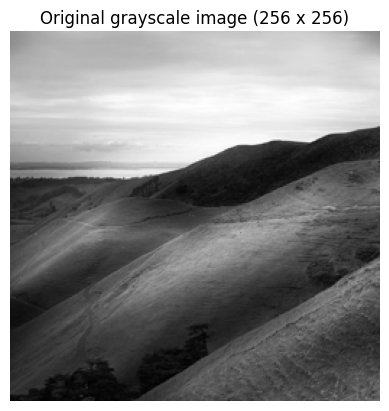

In [5]:
def load_grayscale_image(path, size=(256, 256)):
    """
    Load an image, resize it, convert to grayscale, and return as a float64 matrix.
    """
    img = Image.open(path)
    img = img.resize(size)
    img = img.convert("L")  # grayscale
    return np.array(img, dtype=np.float64)


# Test on one sample image
test_img_path = image_paths[0]
A = load_grayscale_image(test_img_path, size=(256, 256))

print("Loaded image shape:", A.shape)

plt.imshow(A, cmap='gray')
plt.title("Original grayscale image (256 x 256)")
plt.axis('off')
plt.show()


In [6]:
def svd_compress(A, k):
    """
    Compute rank-k approximation of matrix A using SVD.
    Returns Ak, U_k, S_k, Vt_k.
    """
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    U_k = U[:, :k]
    S_k = S[:k]
    Vt_k = Vt[:k, :]
    Ak = U_k @ np.diag(S_k) @ Vt_k
    return Ak, U_k, S_k, Vt_k

def relative_error(A, Ak):
    """
    Relative Frobenius norm error ||A - Ak||_F / ||A||_F.
    """
    num = np.linalg.norm(A - Ak, 'fro')
    den = np.linalg.norm(A, 'fro')
    return num / den

def compression_ratio(m, n, k):
    """
    Compression ratio: (original values) / (values in rank-k SVD).
    Original: m*n
    Rank-k SVD: m*k + n*k + k
    """
    original = m * n
    compressed = m * k + n * k + k
    return original / compressed


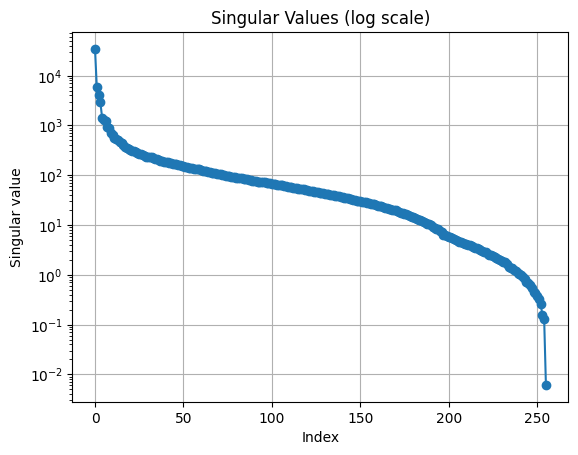

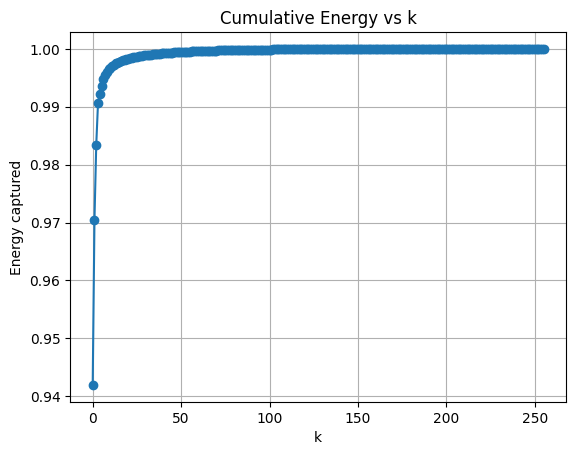

In [7]:
# Compute SVD for the sample image
U, S, Vt = np.linalg.svd(A, full_matrices=False)

# Plot singular values (log scale)
plt.figure()
plt.semilogy(S, marker='o')
plt.title("Singular Values (log scale)")
plt.xlabel("Index")
plt.ylabel("Singular value")
plt.grid(True)
plt.show()

# Cumulative energy
energy = np.cumsum(S**2) / np.sum(S**2)

plt.figure()
plt.plot(energy, marker='o')
plt.title("Cumulative Energy vs k")
plt.xlabel("k")
plt.ylabel("Energy captured")
plt.grid(True)
plt.show()


Energy threshold 90% -> k = 1
Energy threshold 95% -> k = 2
Energy threshold 99% -> k = 4
k for ~95% energy: 2


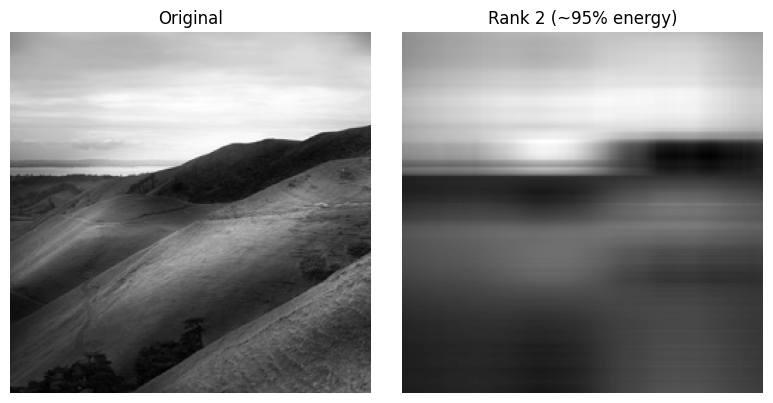

In [8]:
def find_k_for_energy(S, threshold=0.95):
    """
    Find smallest k such that cumulative energy >= threshold.
    """
    energy = np.cumsum(S**2) / np.sum(S**2)
    k = np.searchsorted(energy, threshold) + 1
    return k, energy

for thr in [0.90, 0.95, 0.99]:
    k_thr, _ = find_k_for_energy(S, threshold=thr)
    print(f"Energy threshold {thr*100:.0f}% -> k = {k_thr}")

# Example: reconstruct with ~95% energy
k_95, energy_curve = find_k_for_energy(S, threshold=0.95)
print("k for ~95% energy:", k_95)

Ak_95, _, _, _ = svd_compress(A, k_95)
Ak_95 = np.clip(Ak_95, 0, 255)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(A, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Ak_95, cmap='gray')
plt.title(f"Rank {k_95} (~95% energy)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [9]:
img_path = image_paths[0]  # use first image again
A = load_grayscale_image(img_path, size=(256, 256))
m, n = A.shape
print(f"Image shape: {m} x {n}")

k_values = [5, 20, 50, 100]
reconstructed_images = []
errors = []
crs = []

for k in k_values:
    Ak, U_k, S_k, Vt_k = svd_compress(A, k)
    Ak_clipped = np.clip(Ak, 0, 255)
    reconstructed_images.append(Ak_clipped)

    err = relative_error(A, Ak_clipped)
    cr = compression_ratio(m, n, k)
    errors.append(err)
    crs.append(cr)

    print(f"k = {k:3d} | Relative Error = {err:.4f} | Compression Ratio = {cr:.2f}")


Image shape: 256 x 256
k =   5 | Relative Error = 0.0880 | Compression Ratio = 25.55
k =  20 | Relative Error = 0.0421 | Compression Ratio = 6.39
k =  50 | Relative Error = 0.0235 | Compression Ratio = 2.56
k = 100 | Relative Error = 0.0104 | Compression Ratio = 1.28


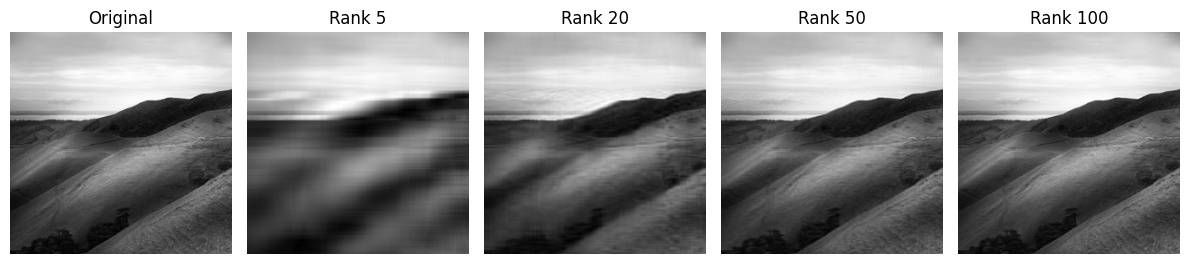

In [10]:
plt.figure(figsize=(12, 6))

# Original
plt.subplot(1, len(k_values) + 1, 1)
plt.imshow(A, cmap='gray')
plt.title("Original")
plt.axis('off')

# Rank-k images
for i, (k, Ak) in enumerate(zip(k_values, reconstructed_images), start=2):
    plt.subplot(1, len(k_values) + 1, i)
    plt.imshow(Ak, cmap='gray')
    plt.title(f"Rank {k}")
    plt.axis('off')

plt.tight_layout()
plt.show()


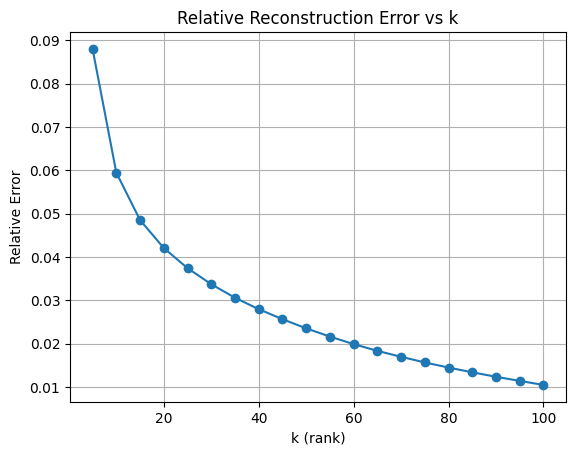

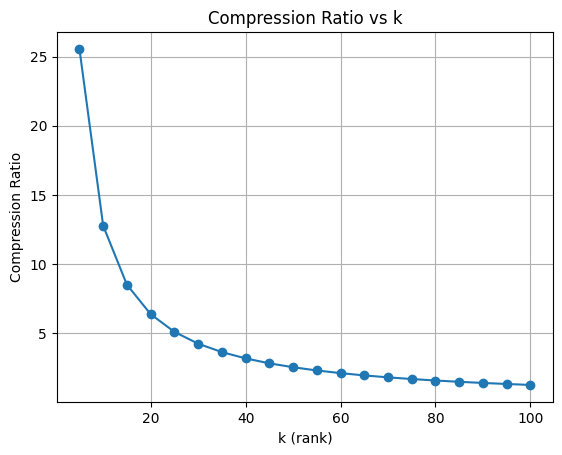

In [11]:
k_list = list(range(5, 101, 5))
errors_curve = []
cr_curve = []

for k in k_list:
    Ak, _, _, _ = svd_compress(A, k)
    Ak_clipped = np.clip(Ak, 0, 255)
    errors_curve.append(relative_error(A, Ak_clipped))
    cr_curve.append(compression_ratio(m, n, k))

# Relative Error vs k
plt.figure()
plt.plot(k_list, errors_curve, marker='o')
plt.xlabel("k (rank)")
plt.ylabel("Relative Error")
plt.title("Relative Reconstruction Error vs k")
plt.grid(True)
plt.show()

# Compression Ratio vs k
plt.figure()
plt.plot(k_list, cr_curve, marker='o')
plt.xlabel("k (rank)")
plt.ylabel("Compression Ratio")
plt.title("Compression Ratio vs k")
plt.grid(True)
plt.show()


In [12]:
def analyze_multiple_images(image_paths, k_values, size=(256, 256)):
    """
    For each image and each k, compute average error and compression ratio.
    """
    errors_dict = {k: [] for k in k_values}
    cr_dict = {k: [] for k in k_values}
    
    for path in image_paths:
        A = load_grayscale_image(path, size=size)
        m, n = A.shape
        
        for k in k_values:
            Ak, _, _, _ = svd_compress(A, k)
            Ak_clipped = np.clip(Ak, 0, 255)
            errors_dict[k].append(relative_error(A, Ak_clipped))
            cr_dict[k].append(compression_ratio(m, n, k))
    
    avg_errors = {k: np.mean(errors_dict[k]) for k in k_values}
    avg_crs = {k: np.mean(cr_dict[k]) for k in k_values}
    return avg_errors, avg_crs

# Use the first N images (already in image_paths)
k_values_small = [5, 20, 50, 100]

avg_errors, avg_crs = analyze_multiple_images(image_paths, k_values_small)

print(f"Average over {len(image_paths)} images:")
for k in k_values_small:
    print(f"k = {k:3d} | Avg Error = {avg_errors[k]:.4f} | Avg CR = {avg_crs[k]:.2f}")


Average over 10 images:
k =   5 | Avg Error = 0.1082 | Avg CR = 25.55
k =  20 | Avg Error = 0.0617 | Avg CR = 6.39
k =  50 | Avg Error = 0.0340 | Avg CR = 2.56
k = 100 | Avg Error = 0.0139 | Avg CR = 1.28


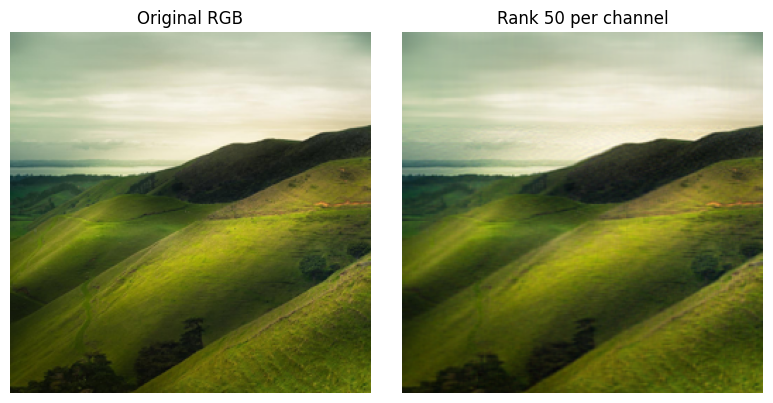

In [13]:
def load_color_image(path, size=(256, 256)):
    """
    Load an image, resize it, convert to RGB, and return as float64 array (H, W, 3).
    """
    img = Image.open(path)
    img = img.resize(size)
    img = img.convert("RGB")
    return np.array(img, dtype=np.float64)

def svd_compress_color(img_rgb, k):
    """
    Apply SVD compression separately to each RGB channel.
    """
    H, W, C = img_rgb.shape
    channels = []
    for c in range(C):
        A = img_rgb[:, :, c]
        Ak, _, _, _ = svd_compress(A, k)
        Ak = np.clip(Ak, 0, 255)
        channels.append(Ak)
    Ak_rgb = np.stack(channels, axis=2)
    return Ak_rgb

# Test on one color image (can reuse test_img_path or another)
color_img_path = image_paths[0]  # if original is color
img_rgb = load_color_image(color_img_path, size=(256, 256))

k_color = 50
Ak_rgb = svd_compress_color(img_rgb, k_color)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb.astype(np.uint8))
plt.title("Original RGB")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(Ak_rgb.astype(np.uint8))
plt.title(f"Rank {k_color} per channel")
plt.axis('off')

plt.tight_layout()
plt.show()
